# RGI11 (Central Europe)

F. Roura-Adseiras & Fabien Maussion

Goal:
- Alps: updates of the Paul 2003 dataset
- Pytrenees: new inventory by Izagirre

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import (mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, 
                   find_duplicates, open_zip_shapefile, correct_geoms, fix_overaps)
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 11

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# Izaguirre file for GLIMS check 
ref_reg_file_p = os.path.join(data_dir, 'l0_support_data', 'pyrenees2000.zip') 

# Frank file for GLIMS check 
ref_reg_file_a = os.path.join(data_dir, 'l0_support_data', 'C3S_GI_RGI11_L5_2003.zip') 

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '11_rgi60_CentralEurope.zip')

In [3]:
# Support data
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the GLIMS input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, _ = submission_summary(shp)
sdf

N       A                                           analysts  \
subm_id                                                                    
1          41     7.4                                           Taschner   
301         5     3.3                                           Taschner   
501        45     2.3                                          Iacovelli   
531       132    37.0             Rott, Schicker, Schwaizer (nee Bippus)   
532       155    61.0                   Schicker, Schwaizer (nee Bippus)   
533       896   896.8                                               Paul   
558        10     8.5                                          Vantadori   
568       660   302.4                                            Rabatel   
569       537   343.0                                            Rabatel   
579      1999   944.0                                            Fischer   
593      7572  2086.8                                               Paul   
594       912   766.0                                               Wipf   
595      1970  1063.1                                             Maisch   
596      2010   944.2                                            Fischer   
598       399   107.7                                               Paul   
599      2061  1285.6                                         Benz, Wipf   
601       871   555.5                           Fischer, Kuhn, Lambrecht   
602      1331   474.3                           Fischer, Kuhn, Lambrecht   
603      1403   415.2                                            Fischer   
613       654   918.3                                            Fischer   
615       903   368.3                                          Smiraglia   
640       581   275.3                                            Antoine   
641       541   368.8                                            Antoine   
663       615   172.0                      Nemec, Schwaizer (nee Bippus)   
664        90    16.5                      Nemec, Schwaizer (nee Bippus)   
665       322    67.7                      Nemec, Schwaizer (nee Bippus)   
666       206    66.9                      Nemec, Schwaizer (nee Bippus)   
667       196    35.8                      Nemec, Schwaizer (nee Bippus)   
668         1     6.0                      Nemec, Schwaizer (nee Bippus)   
710      4407  1806.2  Azzoni, Fugazza, Le Bris, Nemec, Paul, Rabatel...   
715        47     4.2                                           Izagirre   
731      4060  2120.3                       Frey, Le Bris, Paul, Rastner   
818      3722  2194.1          Braun, Lippl, Malz, Seehaus, Sommer, Zemp   
819      4070  1754.5          Braun, Lippl, Malz, Seehaus, Sommer, Zemp   
820      4041  1653.0          Braun, Lippl, Malz, Seehaus, Sommer, Zemp   

                     submitters  release_date              geog_area  \
subm_id                                                                
1                         Ranzi          2006           Italian Alps   
301                       Ranzi          2006           Italian Alps   
501                       Ranzi          2006           Italian Alps   
531                        Rott          2008          Austrian Alps   
532                        Rott          2008          Austrian Alps   
533                        Paul          2009          European Alps   
558                       Ranzi          2012           Italian Alps   
568                     Rabatel          2013            French Alps   
569                     Rabatel          2013            French Alps   
579                     Fischer          2013             Swiss Alps   
593                        Paul          2016          European Alps   
594                        Paul          2016          European Alps   
595                        Paul          2016          European Alps   
596                     Fischer          2016             Swiss Alps   
598                        Paul          2016  

In [6]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [7]:
# For Alps we use 'subm_id' = 731 as our main dataset
RGI_a = shp.loc[shp['subm_id'] == 731].copy()

# Sel by size
print(len(RGI_a))
RGI_a = size_filter(RGI_a)
len(RGI_a)

4060


4034

In [8]:
# For Pyrenees we use 'subm_id' = 715 as our main dataset
RGI_p = shp.loc[shp['subm_id'] == 715].copy()

# Sel by size
print(len(RGI_p))
RGI_p = size_filter(RGI_p)
len(RGI_p)

47


45

In [9]:
# combine the geodataframes
rgi7 = pd.concat([RGI_a, RGI_p])
rgi7['is_rgi6'] = False

### Some sanity checks 

In [10]:
rgi7 = correct_geoms(rgi7)

Found 65 invalid geometries out of 4079.
After correction, 0 geometries are still invalid.
Area changed by 41.0 m2 (0.0000%, or 0 tiny glaciers)


In [11]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [12]:
rgi7 = fix_overaps(rgi7)

Finding intersecting geometries
Computing overlap of intersecting pairs
Found 14 overlaps out of 4079. Correcting...
After correction, Area changed by -35505.1 m2 (-0.0017%, or -3 tiny glaciers)
Final check...
Finding intersecting geometries
Computing overlap of intersecting pairs
OK! Check done


In [13]:
rgi7 = correct_geoms(rgi7)

Found 0 invalid geometries out of 4079.


In [14]:
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

4079
4079


In [15]:
sdf, df_class = submission_summary(rgi7)
df_class

N  N NA
subm_id            
731      4034  4034
715        45    45

In [16]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

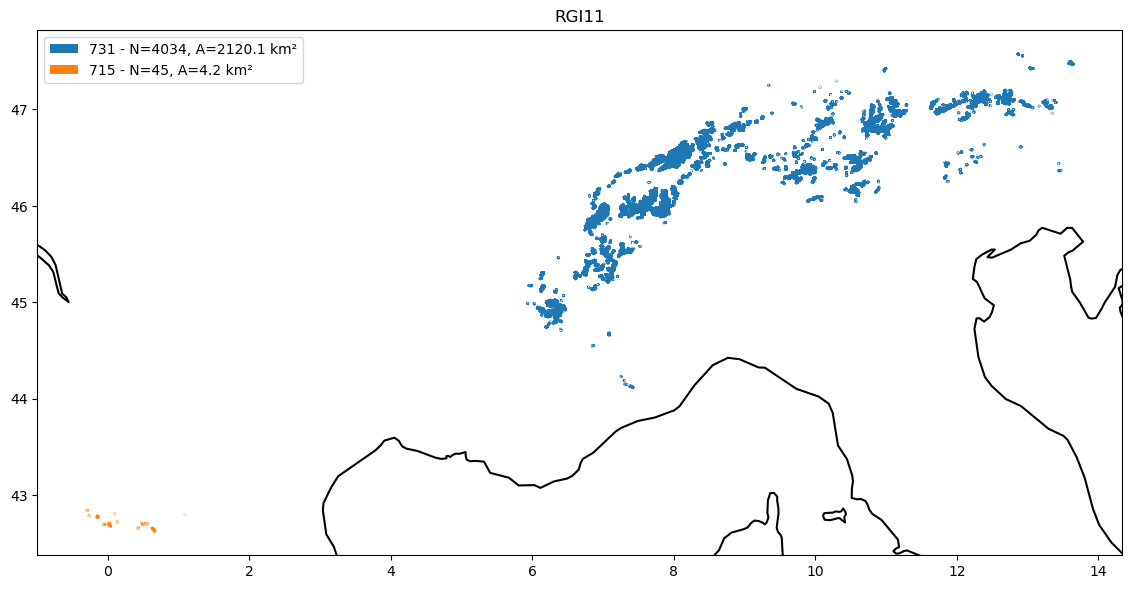

In [17]:
plot_map(rgi7, reg, loc='upper left', linewidth=2)

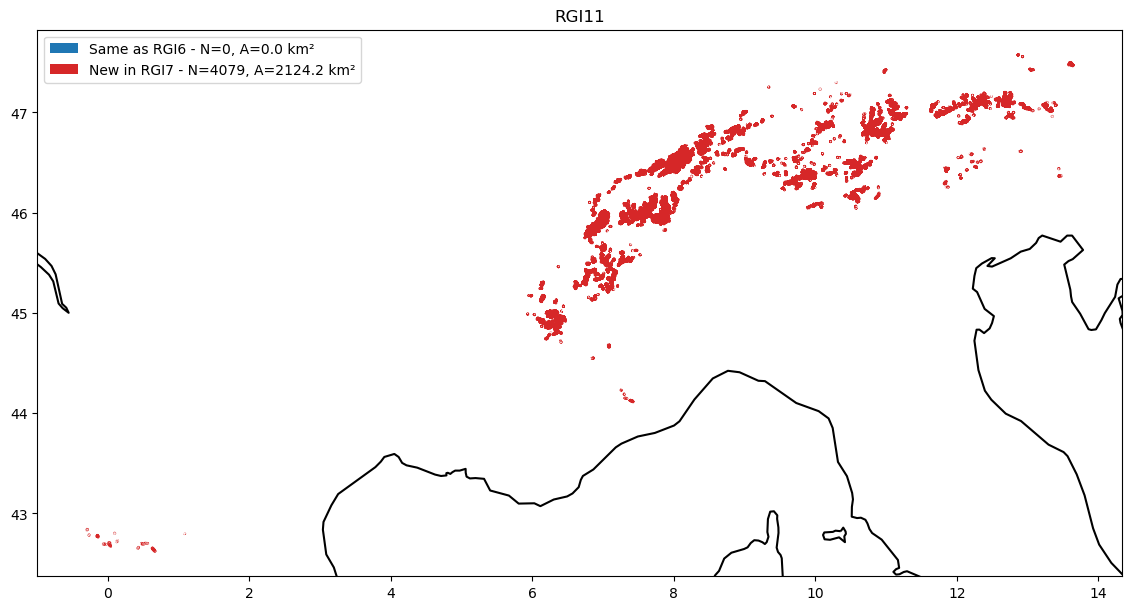

In [18]:
plot_map(rgi7, reg, loc='upper left', linewidth=2, is_rgi6=True)

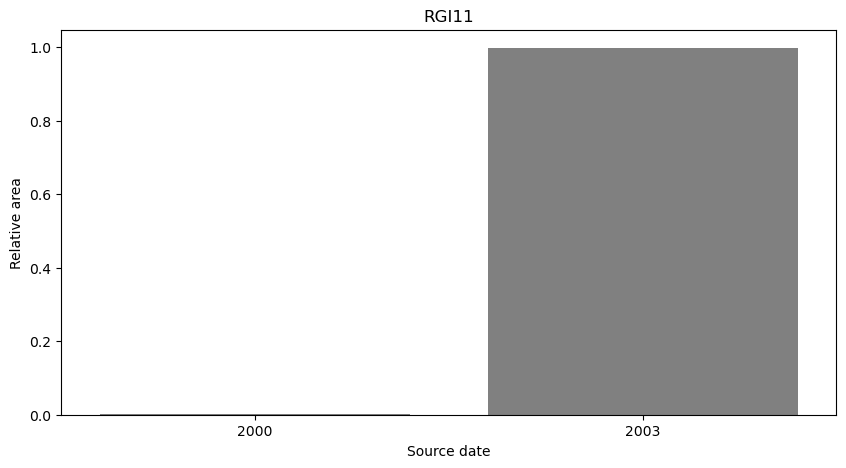

In [19]:
plot_date_hist(rgi7, reg)

### Text for github

In [20]:
fgh = sdf.T
fgh

subm_id                                 731       715
N                                      4034        45
A                                    2120.1       4.2
analysts       Frey, Le Bris, Paul, Rastner  Izagirre
submitters                             Paul  Izagirre
release_date                           2021      2020
geog_area                     European Alps  Pyrenees
src_date_mode                          2003      2000
src_date_min                           2003      2000
src_date_max                           2003      2000

In [21]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 731                          | 715      |
|:--------------|:-----------------------------|:---------|
| N             | 4034                         | 45       |
| A             | 2120.1                       | 4.2      |
| analysts      | Frey, Le Bris, Paul, Rastner | Izagirre |
| submitters    | Paul                         | Izagirre |
| release_date  | 2021                         | 2020     |
| geog_area     | European Alps                | Pyrenees |
| src_date_mode | 2003                         | 2000     |
| src_date_min  | 2003                         | 2000     |
| src_date_max  | 2003                         | 2000     |


## Write out and tar 

In [22]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI11/
RGI11/RGI11.shx
RGI11/RGI11.prj
RGI11/RGI11.cpg
RGI11/RGI11.dbf
RGI11/RGI11.shp
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI11.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI11'], returncode=0)


## New RGI-file created - Check result!

Load reference data (here RGI6 and the original contributions) to enable comparison

In [ ]:
# load reference data
from utils import open_zip_shapefile
ref_rgi6 = open_zip_shapefile(rgi6_reg_file)

# Al
ref_a = open_zip_shapefile(os.path.join(support_dir, 'C3S_GI_RGI11_L5_2003.zip'))

# Py
ref_p = open_zip_shapefile(os.path.join(support_dir, 'pyrenees2000.zip'), exclude_pattern='__MACOSX', include_pattern='glaciers_')

### Compare new RGI7-file to RGI6

#### Number of elements (differences do not necessarily depict problems)

In [ ]:
print('Number of glaciers in new RGI:', len(rgi7))
print('Number of glaciers in RGI6:', len(ref_rgi6))
print('Difference:', len(rgi7)-len(ref_rgi6))

### How many nominal glaciers were there in RGI06?

In [ ]:
len(ref_rgi6.loc[ref_rgi6.Status == 2])

### Total area

In [ ]:
# add an area field to RGI_ss and reference data
ref_rgi6['area'] = ref_rgi6.to_crs({'proj':'cea'}).area
ref_p['area'] = ref_p.to_crs({'proj':'cea'}).area

In [ ]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_rgi6['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

## Comparison to reference products

### Pyrennees (no problem) 

In [ ]:
# add an area field to RGI_ss and reference data
RGI_p['area'] = RGI_p.to_crs({'proj':'cea'}).area
ref_p['area'] = ref_p.to_crs({'proj':'cea'}).area

print(len(ref_p))
ref_p = ref_p.loc[np.round(ref_p['area'] * 1e-6, 3) >= 0.01].copy()
len(ref_p)

In [ ]:
print('Number of glaciers in new RGI subset:', len(RGI_p))
print('Number of glaciers in reference data (izaguirre):', len(ref_p))
print('Difference:', len(RGI_p)-len(ref_p))

In [ ]:
# print and compare area values
Area_rgi = RGI_p['area'].sum()/1000000
print('Area RGI [km²]:', Area_rgi)
Area_ref = ref_p['area'].sum()/1000000
print('Area ref:', Area_ref)
d = (Area_rgi - Area_ref)
d_perc = (d/Area_rgi*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

### Alps (no problem)

In [ ]:
# add an area field to RGI_ss and reference data
RGI_a['area'] = RGI_a.to_crs({'proj':'cea'}).area
ref_a['area'] = ref_a.to_crs({'proj':'cea'}).area

print(len(ref_a))
ref_a = ref_a.loc[np.round(ref_a['area'] * 1e-6, 3) >= 0.01].copy()
len(ref_a)

In [ ]:
print('Number of glaciers in new RGI subset:', len(RGI_a))
print('Number of glaciers in reference data (Franck):', len(ref_a))
print('Difference:', len(RGI_a)-len(ref_a))

In [ ]:
# print and compare area values
Area_rgi = RGI_a['area'].sum()/1000000
print('Area RGI [km²]:', Area_rgi)
Area_ref = ref_a['area'].sum()/1000000
print('Area ref:', Area_ref)
d = (Area_rgi - Area_ref)
d_perc = (d/Area_rgi*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

For Alps, no substantial differences between the original Frank and glims inventories, except for a glacier, that we want to find now:

### Find the missing glacier 

In [ ]:
df_ref = ref_a.copy()
rgi7 = RGI_a.copy()
df_ref = df_ref.to_crs(rgi7.crs)

In [ ]:
import progressbar

In [ ]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [ ]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [ ]:
df_ref_orig = df_ref.copy()

In [ ]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.01):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

In [ ]:
print(len(not_found), len(df_ref))

In [ ]:
df_ref.plot(edgecolor='k', column='area');

In [ ]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]
pb_rgi7.plot(edgecolor='k', column='area');

**Conclusion: there is no problem in GLIMS!!!**